In [1]:
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from trad_ml_01_feature_engineering_func import (
    plot_label_distribution
    , get_qid_with_nlp_string_tup_pair
    , get_list_of_lemmatized_string_with_no_stop_words
    , get_qid_pair_with_label
    , generate_df
    , add_thefuzz_features
)

from util_generate_raw_data import generate_raw_data
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset and split into train and testset

In [2]:
lst_of_files = ['train_kaggle.csv', 'train_glue.tsv', 'dev_glue.tsv']
df = generate_raw_data(*lst_of_files)
X, y = df.drop('is_duplicate', axis = 1), df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

train set dimensions:  (808566, 6)
train set dimensions after dropping duplicates by question pair:  (404290, 6)
train set dimensions after dropping duplicates by qid pair:  (404290, 6)


### Dataset slightly imbalanced (about 3:2) but still reasonable

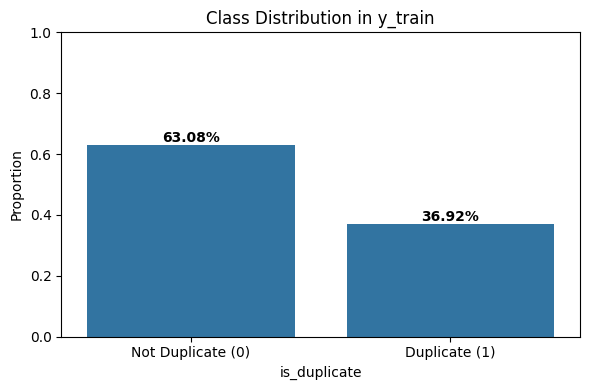

In [3]:
plot_label_distribution(y_train)

### Feature Engineering from raw questions for train set

In [3]:
nlp = spacy.load('en_core_web_sm', exclude = ['parser', 'ner', 'entity_linker', 
                                              'entity_ruler', 'textcat', 'textcat_multilabel', 
                                              'morphologizer', 'senter', 'sentencizer'])
'''
Obtain the following:
lemma_str_train: list of strings after stop word removal and lemmatization
q1q2_id_label_triple_train: array of triple with qid1, qid2, label
'''
id_qn_lemma_str_pair_train = get_qid_with_nlp_string_tup_pair(X_train, nlp)
lemma_str_train = get_list_of_lemmatized_string_with_no_stop_words(id_qn_lemma_str_pair_train)
q1q2_id_label_triple_train = get_qid_pair_with_label(X_train, y_train)

'''
qn_score_matrix_train: normalised TF-IDF vector matrix obtained from lemma_str_train
'''
tfidf_vectorizer = TfidfVectorizer()
qn_score_matrix_train = tfidf_vectorizer.fit_transform(lemma_str_train)
qn_score_matrix_train = normalize(qn_score_matrix_train, norm = 'l2', axis = 1)

'''
id_to_score_vector_train: mapping from qid to TF-IDF score vector
for computation of cosine similarity, manhattan distance, euclidean distance
'''
qn_id_train = list(map(lambda x: x[0], id_qn_lemma_str_pair_train))
id_to_score_vector_train = dict(zip(qn_id_train, qn_score_matrix_train))

'''
id_to_presence_vector_train: mapping from qid to presence vector
for computation of jaccard distance
'''
presence_vectorizer = CountVectorizer(binary = True)
lemma_presence_matrix_train = presence_vectorizer.fit_transform(lemma_str_train)
id_to_presence_vector_train = dict(zip(qn_id_train, lemma_presence_matrix_train))

'''
df containing
id1
, id2, 
, cosine_similarity, 
, manhattan_dist, 
, euclidean_dist, 
, jaccard_dist, 
, is_duplicate
'''
df_train = generate_df(q1q2_id_label_triple_train, id_to_score_vector_train, id_to_presence_vector_train)

### More feature engineering (fuzz features) for train set

In [4]:

'''
include 
fuzz ratio
, fuzz partial ratio
, token sort ratio
, token set ratio
'''
df_train_with_fuzz = add_thefuzz_features(df_train, X_train)
new_order  = ['id1','id2',
              'cosine_similarity', 'manhattan_dist', 'euclidean_dist', 'jaccard_dist', 
              'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 
              'is_duplicate']
df_train_with_fuzz = df_train_with_fuzz[new_order]

df_train.to_csv('data/original_train_data.csv', index = False)
df_train_with_fuzz.to_csv('data/train_data_with_fuzz_features.csv', index = False)

### Feature Engineering from raw questions for test set

In [5]:
'''
Obtain the following:
lemma_str_test: list of strings after stop word removal and lemmatization
q1q2_id_label_triple_test: array of triple with qid1, qid2, label
'''

id_qn_lemma_str_pair_test = get_qid_with_nlp_string_tup_pair(X_test, nlp)
lemma_str_test = get_list_of_lemmatized_string_with_no_stop_words(id_qn_lemma_str_pair_test)
q1q2_id_label_triple_test = get_qid_pair_with_label(X_test, y_test)

'''
qn_score_matrix_test: normalised TF-IDF vector matrix obtained from lemma_str_train
'''
qn_score_matrix_test = tfidf_vectorizer.transform(lemma_str_test)
qn_score_matrix_test = normalize(qn_score_matrix_test, norm = 'l2', axis = 1)

'''
id_to_score_vector_test: mapping from qid to TF-IDF score vector
for computation of cosine similarity, manhattan distance, euclidean distance
'''
qn_id_test = list(map(lambda x: x[0], id_qn_lemma_str_pair_test))
id_to_score_vector_test = dict(zip(qn_id_test, qn_score_matrix_test))

'''
id_to_presence_vector_test: mapping from qid to presence vector
for computation of jaccard distance
'''
lemma_presence_matrix_test = presence_vectorizer.transform(lemma_str_test)
id_to_presence_vector_test = dict(zip(qn_id_test, lemma_presence_matrix_test))

'''
df containing
id1
, id2, 
, cosine_similarity, 
, manhattan_dist, 
, euclidean_dist, 
, jaccard_dist, 
, is_duplicate
'''
df_test = generate_df(q1q2_id_label_triple_test, id_to_score_vector_test, id_to_presence_vector_test)

### More feature engineering (fuzz features) for test set

In [11]:
'''
include 
fuzz ratio
, fuzz partial ratio
, token sort ratio
, token set ratio
'''
df_test_with_fuzz = add_thefuzz_features(df_test, X_test)
df_test_with_fuzz = df_test_with_fuzz[new_order]

df_test.to_csv('data/original_test_data.csv', index = False)
df_test_with_fuzz.to_csv('data/test_data_with_fuzz_features.csv', index = False)

In [12]:
df_test.to_csv('data/original_test_data.csv', index = False)
df_test_with_fuzz.to_csv('data/test_data_with_fuzz_features.csv', index = False)
df_train.to_csv('data/original_train_data.csv', index = False)
df_train_with_fuzz.to_csv('data/train_data_with_fuzz_features.csv', index = False)